In [9]:
# ==========================================================
# BLOCCO 1️⃣ — Caricamento Dataset e Class Weights (Imbalanced)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

print("📂 Caricamento dataset e class weights per training (dataset sbilanciato)...")

# ----------------------------------------------------------
# 1️⃣ Percorsi file salvati
# ----------------------------------------------------------
base_path = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22"

train_test_path = fr"{base_path}\train_test_unbal.npz"
weights_path = fr"{base_path}\class_weights_unbal.npy"

# ----------------------------------------------------------
# 2️⃣ Caricamento dati
# ----------------------------------------------------------
data_npz = np.load(train_test_path, allow_pickle=True)
class_weights = np.load(weights_path, allow_pickle=True).item()

X_train = data_npz["X_train"]
X_test = data_npz["X_test"]
y_train = data_npz["y_train"]
y_test = data_npz["y_test"]

print("✅ Dati caricati correttamente:")
print(" - X_train:", X_train.shape, "| X_test:", X_test.shape)
print(" - Distribuzione y_train:", dict(collections.Counter(y_train)))
print(" - Distribuzione y_test :", dict(collections.Counter(y_test)))

print("\n✅ BLOCCO 1 COMPLETATO: Dataset pronto per il training.")


📂 Caricamento dataset e class weights per training (dataset sbilanciato)...
✅ Dati caricati correttamente:
 - X_train: (248027, 16) | X_test: (62007, 16)
 - Distribuzione y_train: {'Resource Development': 209927, 'Discovery': 12816, 'Other': 2355, 'Reconnaissance': 22929}
 - Distribuzione y_test : {'Resource Development': 52482, 'Discovery': 3204, 'Other': 589, 'Reconnaissance': 5732}

✅ BLOCCO 1 COMPLETATO: Dataset pronto per il training.


In [ ]:
# ==========================================================
# BLOCCO 2️⃣ ✅ Random Forest — TRAINING SU DATASET SBILANCIATO (3-fold + parallel)
# ==========================================================
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, balanced_accuracy_score
)
import collections

print("🏗️ Addestramento Random Forest (dataset sbilanciato, class_weight dinamico, 3-fold)...\n")

# ==========================================================
# 1️⃣ Griglia iperparametri
# ==========================================================
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

param_combinations = list(product(
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['max_features'],
    param_grid['bootstrap']
))

print(f"🔍 GridSearch manuale su {len(param_combinations)} combinazioni (~{len(param_combinations)*3} fit fold per fold)...\n")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # ✅ 3 fold
best_score = -np.inf
best_params = None
results = []

# ==========================================================
# 2️⃣ Ciclo combinazioni + validazione fold per fold
# ==========================================================
for i, (max_depth, min_split, min_leaf, max_feat, boot) in enumerate(param_combinations, 1):
    params = {
        'max_depth': max_depth,
        'min_samples_split': min_split,
        'min_samples_leaf': min_leaf,
        'max_features': max_feat,
        'bootstrap': boot
    }
    print(f"⚙️ Combinazione {i}/{len(param_combinations)} → {params}")
    start = time.time()
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight=class_weights,
            n_jobs=-1,  # parallel
            **params
        )
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='macro')
        fold_scores.append(score)
        print(f"   📈 Fold {fold}/3 → F1 macro = {score:.4f}")

    mean_score = np.mean(fold_scores)
    elapsed = time.time() - start
    print(f"✅ Combinazione {i} completata in {elapsed:.2f}s | F1 medio = {mean_score:.4f}\n")

    results.append((params, mean_score))
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"🏁 GridSearch completata. Miglior F1 = {best_score:.4f}")
print(f"🏆 Migliori iperparametri trovati: {best_params}\n")

# ==========================================================
# 3️⃣ Training finale con i migliori parametri
# ==========================================================
best_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight=class_weights,
    n_jobs=-1,  # parallel
    **best_params
)
best_rf.fit(X_train, y_train)

# ==========================================================
# 4️⃣ Funzione metriche dettagliate con specificità e F1 per classe
# ==========================================================
def print_metrics(y_true, y_pred, name, classes):
    # Metriche globali
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(f"\n📊 Metriche sul {name} set:")
    print(f"Accuracy:            {acc:.4f}")
    print(f"Balanced Accuracy:   {bal_acc:.4f}")
    print(f"Precision (macro):   {prec:.4f}")
    print(f"Recall (macro):      {rec:.4f}")
    print(f"F1-score (macro):    {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # Specificità e F1 per classe + tabella
    metrics = []
    for i, cls in enumerate(classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_cls = f1_score((y_true == cls).astype(int), (y_pred == cls).astype(int))
        metrics.append([cls, spec, f1_cls])

    df_metrics = pd.DataFrame(metrics, columns=["Classe", "Specificità", "F1 Classe"])
    
    print("\n📌 Metriche per classe:")
    print(df_metrics.to_string(index=False))

    # Classification report (per confronto)
    print("\n🧾 Classification Report:")
    report = classification_report(y_true, y_pred, digits=4)
    print(report)


    return f1

# ==========================================================
# 5️⃣ Calcolo metriche train e test
# ==========================================================
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

classes_sorted = np.unique(np.concatenate([y_train, y_test]))
train_f1 = print_metrics(y_train, y_train_pred, "TRAIN", classes_sorted)
test_f1 = print_metrics(y_test, y_test_pred, "TEST", classes_sorted)

# ==========================================================
# 6️⃣ Analisi over/underfitting
# ==========================================================
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")

print("\n✅ BLOCCO 2 COMPLETATO: Random Forest addestrato con class weights (dataset sbilanciato, 3-fold).")


🏗️ Addestramento Random Forest (dataset sbilanciato, class_weight dinamico, 3-fold)...

🔍 GridSearch manuale su 32 combinazioni (~96 fit fold per fold)...

⚙️ Combinazione 1/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
   📈 Fold 1/3 → F1 macro = 0.9989
   📈 Fold 2/3 → F1 macro = 0.9992
   📈 Fold 3/3 → F1 macro = 0.9990
✅ Combinazione 1 completata in 46.68s | F1 medio = 0.9990

⚙️ Combinazione 2/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
   📈 Fold 1/3 → F1 macro = 0.9985
   📈 Fold 2/3 → F1 macro = 0.9994
   📈 Fold 3/3 → F1 macro = 0.9991
✅ Combinazione 2 completata in 68.71s | F1 medio = 0.9990

⚙️ Combinazione 3/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}
   📈 Fold 1/3 → F1 macro = 0.9989
   📈 Fold 2/3 → F1 macro = 0.9992
   📈 Fold 3/3 → F1 macro = 0.9990
✅ Combinazione 3 completat

In [ ]:
# ==========================================================
# BLOCCO 2b ✅ Metriche avanzate, grafici e interpretazione Random Forest (SBILANCIATO)
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
import numpy as np

print("📊 Generazione grafici e visualizzazioni avanzate per Random Forest **SBILANCIATA**...\n")

# ==========================================================
# 1️⃣ Learning Curve
# ==========================================================
print("🧩 **Learning Curve**: mostra come varia la prestazione del modello al crescere del numero di campioni di training.\n"
      "- Una curva *train alta e test bassa* indica **overfitting**.\n"
      "- Curve vicine e stabili → **buona generalizzazione**.\n")

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train, y_train, cv=3, scoring='f1_macro', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Train score", marker='o')
plt.plot(train_sizes, test_mean, label="Test score", marker='s')
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve — Random Forest (SBILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 2️⃣ Confusion Matrix
# ==========================================================
print("\n📊 **Confusion Matrix**: mostra la distribuzione degli errori per classe.\n"
      "- Diagonale = predizioni corrette\n"
      "- Fuori diagonale = errori\n")

plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test, cmap='Blues', normalize='true'
)
plt.title("📊 Confusion Matrix Normalizzata — RF (SBILANCIATO)")
plt.show()

# ==========================================================
# 3️⃣ Precision–Recall Curve (multiclasse)
# ==========================================================
print("\n🎯 **Precision–Recall Curve** — importante nei dataset **sbilanciati**.\n"
      "- Evidenzia capacità di individuare classi minoritarie.\n"
      "- AP (Average Precision) più alto = migliore.\n")

y_test_bin = label_binarize(y_test, classes=classes_sorted)
y_score = best_rf.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes_sorted):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision–Recall Curve Multiclass — RF (SBILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 4️⃣ ROC Curve multiclasse
# ==========================================================
print("\n📈 **ROC Curve — Sensibilità vs Falsi Positivi**.\n"
      "- AUC vicino a 1 → ottima separabilità delle classi.\n")

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes_sorted):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass — RF (SBILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 5️⃣ Feature Importance
# ==========================================================
print("\n🌟 **Feature Importance** — quali feature guidano il modello.\n"
      "- Utile per interpretare i latent factors appresi.\n")

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices],
    y=[f"latent_{i}" for i in indices],
    palette="viridis"
)
plt.title("🌟 Feature Importance — RF (SBILANCIATO)")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()

print("\n✅ Tutti i grafici e metriche avanzate generati con successo (SBILANCIATO)!")


📊 Generazione grafici e visualizzazioni avanzate per Random Forest **SBILANCIATA**...

🧩 **Learning Curve**: mostra come varia la prestazione del modello al crescere del numero di campioni di training.
- Una curva *train alta e test bassa* indica **overfitting**.
- Curve vicine e stabili → **buona generalizzazione**.



NameError: name 'best_rf' is not defined

In [ ]:
# ==========================================================
# BLOCCO 3️⃣ — LightGBM finale (con stampa F1 per fold e best)
# ==========================================================
import numpy as np
import pandas as pd
import lightgbm as lgb
from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

print("⚙️ Avvio addestramento LightGBM (versione finale con log dettagliato)...")

# ==========================================================
# Conversione a DataFrame per evitare warning “feature names”
# ==========================================================
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# ==========================================================
# Parametri e griglia di ricerca
# ==========================================================
param_grid = {
    'num_leaves': [31, 63],
    'max_depth': [10, 15],
    'learning_rate': [0.05, 0.1],
    'min_data_in_leaf': [20, 40],
    'feature_fraction': [0.8, 1.0]
}

param_combinations = list(product(*param_grid.values()))
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_score = -np.inf
best_params = None
results = []

# ==========================================================
# Ciclo combinazioni + validazione fold per fold
# ==========================================================
for i, combo in enumerate(param_combinations, 1):
    params = dict(zip(param_grid.keys(), combo))
    params.update({
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train)),
        'n_jobs': -1,
        'random_state': 42,
        'class_weight': class_weights,
        'verbose': -1
    })
    print(f"\n⚙️ Combinazione {i}/{len(param_combinations)} → {params}")
    start = time.time()

    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_df, y_train), 1):
        X_tr, X_val = X_train_df.iloc[train_idx], X_train_df.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = lgb.LGBMClassifier(**params, n_estimators=500)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)],
                  callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])

        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        fold_scores.append(f1)
        print(f"   📈 Fold {fold}/3 → F1 macro = {f1:.4f}")

    mean_score = np.mean(fold_scores)
    elapsed = time.time() - start
    print(f"✅ Combinazione {i} completata in {elapsed:.2f}s | F1 medio = {mean_score:.4f}\n")

    results.append((params, mean_score))
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print("   🏆 Nuovo best trovato!")

print(f"🏁 GridSearch completata. Miglior F1 = {best_score:.4f}")
print(f"🏆 Migliori iperparametri LightGBM: {best_params}\n")

# ==========================================================
# Training finale con i migliori parametri
# ==========================================================
best_lgb = lgb.LGBMClassifier(**best_params, n_estimators=500)
best_lgb.fit(X_train_df, y_train)

# ==========================================================
# Funzione metriche e matrice di confusione
# ==========================================================
def print_metrics(y_true, y_pred, name, classes):
    # Metriche globali
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"\n📊 Metriche sul {name} set:")
    print(f"Accuracy:            {acc:.4f}")
    print(f"Balanced Accuracy:   {bal_acc:.4f}")
    print(f"Precision (macro):   {prec:.4f}")
    print(f"Recall (macro):      {rec:.4f}")
    print(f"F1-score (macro):    {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # Specificità e F1 per classe + tabella
    metrics = []
    for i, cls in enumerate(classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_cls = f1_score((y_true == cls).astype(int), (y_pred == cls).astype(int))
        metrics.append([cls, spec, f1_cls])

    df_metrics = pd.DataFrame(metrics, columns=["Classe", "Specificità", "F1 Classe"])
    
    print("\n📌 Metriche per classe:")
    print(df_metrics.to_string(index=False))

    # Classification report (per confronto)
    print("\n🧾 Classification Report:")
    report = classification_report(y_true, y_pred, digits=4)
    print(report)

    return f1

# ==========================================================
# Valutazione finale su train e test
# ==========================================================
y_train_pred = best_lgb.predict(X_train_df)
y_test_pred = best_lgb.predict(X_test_df)

classes_sorted = np.unique(np.concatenate([y_train, y_test]))
train_f1 = print_metrics(y_train, y_train_pred, "TRAIN", classes_sorted)
test_f1 = print_metrics(y_test, y_test_pred, "TEST", classes_sorted)

# ==========================================================
# Analisi overfitting / underfitting
# ==========================================================
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")


⚙️ Avvio addestramento LightGBM (versione finale con log dettagliato)...

⚙️ Combinazione 1/32 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.05, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'objective': 'multiclass', 'num_class': 4, 'n_jobs': -1, 'random_state': 42, 'class_weight': {'Discovery': 4.838229556803995, 'Other': 26.32983014861996, 'Reconnaissance': 2.704293689214532, 'Resource Development': 0.2953729153467634}, 'verbose': -1}
   📈 Fold 1/3 → F1 macro = 0.9989
   📈 Fold 2/3 → F1 macro = 0.9989
   📈 Fold 3/3 → F1 macro = 0.9994
✅ Combinazione 1 completata in 28.47s | F1 medio = 0.9991

   🏆 Nuovo best trovato!

⚙️ Combinazione 2/32 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.05, 'min_data_in_leaf': 20, 'feature_fraction': 1.0, 'objective': 'multiclass', 'num_class': 4, 'n_jobs': -1, 'random_state': 42, 'class_weight': {'Discovery': 4.838229556803995, 'Other': 26.32983014861996, 'Reconnaissance': 2.704293689214532, 'Resource Development': 0.295372915


🧩 Learning Curve (Curva di Apprendimento):
- Mostra l’evoluzione delle prestazioni al crescere dei dati di training.
- Se curva train >> test → possibile overfitting.
- Se curve vicine e alte → buon equilibrio e generalizzazione.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


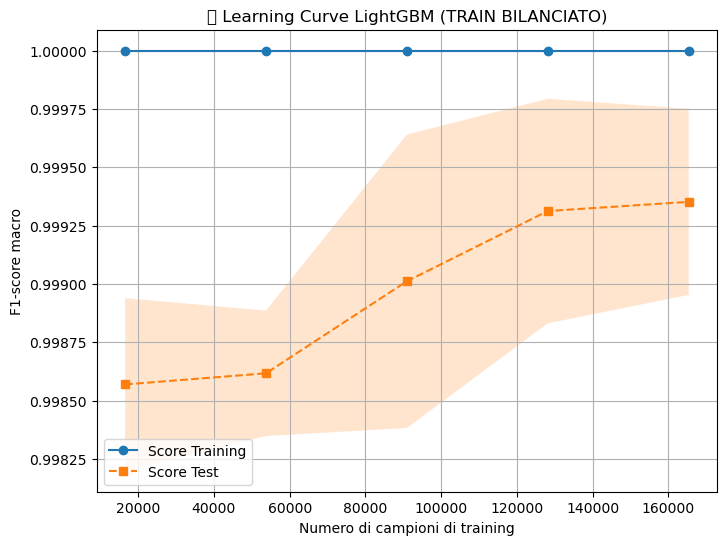

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)



🌟 Feature Importance (Importanza delle Caratteristiche):
- Evidenzia quali latent features influenzano maggiormente il modello.
- Maggiore valore → maggiore contributo alla decisione.



C:\Users\maria\AppData\Local\Temp\ipykernel_20144\3808356667.py:58: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


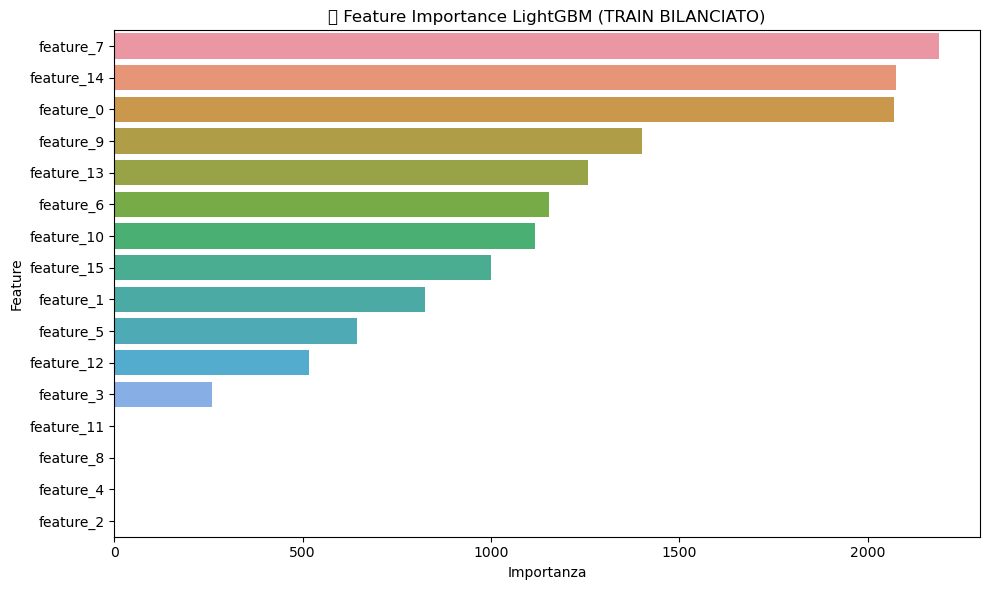

In [ ]:
# ==========================================================
# 📊 Metriche avanzate e interpretazione — LightGBM
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
import numpy as np

print("\n📊 Generazione grafici e visualizzazioni avanzate per **LightGBM**...\n")

# ==========================================================
# 1️⃣ Learning Curve
# ==========================================================
print("🧩 **Learning Curve**:\n"
      "- Valuta l’apprendimento al crescere del training set.\n"
      "- Train ≫ Test → possibile overfitting.\n"
      "- Curve vicine → buona generalizzazione.\n")

train_sizes, train_scores, test_scores = learning_curve(
    best_lgb, X_train_df, y_train, cv=3, scoring='f1_macro', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean, test_mean = train_scores.mean(axis=1), test_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, marker='o', label="Train score")
plt.plot(train_sizes, test_mean, marker='s', label="Test score")
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve — LightGBM")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 2️⃣ Confusion Matrix
# ==========================================================
print("\n📊 **Confusion Matrix** — performance LightGBM\n")

plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    best_lgb, X_test_df, y_test, cmap='Blues', normalize='true'
)
plt.title("📊 Confusion Matrix Normalizzata — LightGBM")
plt.show()

# ==========================================================
# 3️⃣ Precision-Recall Curve (multiclasse)
# ==========================================================
print("\n🎯 **Precision–Recall Curve** — utile con squilibrio classi\n")

y_test_bin = label_binarize(y_test, classes=classes_sorted)
y_score = best_lgb.predict_proba(X_test_df)

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes_sorted):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve — LightGBM")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 4️⃣ ROC Curve (multiclasse)
# ==========================================================
print("\n📈 **ROC Curve** — sensibilità vs falsi positivi\n")

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes_sorted):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve — LightGBM")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 5️⃣ Feature Importance
# ==========================================================
print("\n🌟 **Feature Importance** — LightGBM\n")

importances = best_lgb.feature_importances_
indices = np.argsort(importances)[::-1]
feat_sorted = [feature_names[i] for i in indices]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=feat_sorted, palette="viridis")
plt.title("🌟 Feature Importance — LightGBM")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()

print("\n✅ Tutti i grafici e metriche avanzate LightGBM generati!")


In [ ]:
# ==========================================================
# BLOCCO 4️⃣ — XGBoost finale (gestione pesi + target stringhe + tracking)
# ==========================================================
import numpy as np
import pandas as pd
import xgboost as xgb
from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, balanced_accuracy_score, classification_report
import time

print("⚙️ Avvio addestramento XGBoost (versione finale con tracking)...")

# ==========================================================
# 1️⃣ Conversione a DataFrame e mappatura classi
# ==========================================================
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

classes_sorted = np.unique(np.concatenate([y_train, y_test]))
class_mapping = {cls: i for i, cls in enumerate(classes_sorted)}
inverse_mapping = {v: k for k, v in class_mapping.items()}

y_train_num = np.array([class_mapping[y] for y in y_train])
y_test_num = np.array([class_mapping[y] for y in y_test])

# Mappa anche i pesi in base alle etichette numeriche
class_weights_num = {class_mapping[k]: v for k, v in class_weights.items()}

# ==========================================================
# 2️⃣ Griglia iperparametri + CV
# ==========================================================
param_grid = {
    'max_depth': [6, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 5]
}
param_combinations = list(product(*param_grid.values()))
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_score = -np.inf
best_params = None
results = []

print(f"\n🚀 Inizio GridSearch manuale (totale combinazioni = {len(param_combinations)})...")

# ==========================================================
# 3️⃣ Ciclo combinazioni + validazione fold per fold
# ==========================================================
for i, combo in enumerate(param_combinations, 1):
    params = dict(zip(param_grid.keys(), combo))
    params.update({
        'objective': 'multi:softmax',
        'num_class': len(classes_sorted),
        'n_jobs': -1,
        'random_state': 42,
        'eval_metric': 'mlogloss'
    })

    print(f"⚙️ Combinazione {i}/{len(param_combinations)} → {params}")
    start_time = time.time()

    fold_scores = []
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_df, y_train_num), 1):
        X_tr, X_val = X_train_df.iloc[train_idx], X_train_df.iloc[val_idx]
        y_tr, y_val = y_train_num[train_idx], y_train_num[val_idx]

        sample_weights = np.array([class_weights_num[y] for y in y_tr])

        model = xgb.XGBClassifier(**params, n_estimators=500, use_label_encoder=False, verbosity=0)
        model.fit(X_tr, y_tr, sample_weight=sample_weights)

        y_pred = model.predict(X_val)
        fold_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
        fold_scores.append(fold_f1)
        print(f"   📈 Fold {fold_idx}/3 → F1 macro = {fold_f1:.4f}")

    mean_score = np.mean(fold_scores)
    elapsed = time.time() - start_time
    print(f"✅ Combinazione {i} completata in {elapsed:.2f}s | F1 medio = {mean_score:.4f}\n")

    results.append((params, mean_score))
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"🏁 GridSearch completata. Miglior F1 = {best_score:.4f}")
print(f"🏆 Migliori iperparametri trovati: {best_params}\n")

# ==========================================================
# 4️⃣ Training finale con migliori parametri
# ==========================================================
print("🎯 Addestramento finale con i migliori iperparametri...")
sample_weights_full = np.array([class_weights_num[y] for y in y_train_num])

best_xgb = xgb.XGBClassifier(**best_params, n_estimators=500, use_label_encoder=False, verbosity=0)
best_xgb.fit(X_train_df, y_train_num, sample_weight=sample_weights_full)

# ==========================================================
# 5️⃣ Funzione metriche e confusion matrix
# ==========================================================
def print_metrics(y_true, y_pred, name, inverse_mapping):
    """
    Stampa metriche complete per un modello multiclasse.
    - y_true e y_pred devono essere numerici (interi)
    - inverse_mapping: dict {numero -> classe originale stringa} per stampare i nomi
    """
    from sklearn.metrics import (
        accuracy_score, balanced_accuracy_score,
        precision_score, recall_score, f1_score,
        confusion_matrix, classification_report
    )
    import pandas as pd

    # Metriche globali
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"\n📊 Metriche sul {name} set:")
    print(f"Accuracy:            {acc:.4f}")
    print(f"Balanced Accuracy:   {bal_acc:.4f}")
    print(f"Precision (macro):   {prec:.4f}")
    print(f"Recall (macro):      {rec:.4f}")
    print(f"F1-score (macro):    {f1:.4f}")

    # Confusion matrix
    classes_num = np.arange(len(inverse_mapping))
    cm = confusion_matrix(y_true, y_pred, labels=classes_num)

    # Metriche per classe
    metrics = []
    for i, cls_num in enumerate(classes_num):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_cls = f1_score((y_true == cls_num).astype(int), (y_pred == cls_num).astype(int), zero_division=0)
        metrics.append([inverse_mapping[cls_num], spec, f1_cls])

    df_metrics = pd.DataFrame(metrics, columns=["Classe", "Specificità", "F1 Classe"])
    print("\n📌 Metriche per classe:")
    print(df_metrics.to_string(index=False))

    # Classification report
    print("\n🧾 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[inverse_mapping[i] for i in classes_num], digits=4))

    return f1


# ==========================================================
# 6️⃣ Valutazione finale
# ==========================================================
y_train_pred_num = best_xgb.predict(X_train_df)
y_test_pred_num = best_xgb.predict(X_test_df)

train_f1 = print_metrics(y_train_num, y_train_pred_num, "TRAIN", classes_sorted)
test_f1 = print_metrics(y_test_num, y_test_pred_num, "TEST", classes_sorted)

gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")

print(f"\n🏆 Migliori iperparametri XGBoost: {best_params}")


⚙️ Avvio addestramento XGBoost (versione finale con tracking)...

🚀 Inizio GridSearch manuale (totale combinazioni = 32)...
⚙️ Combinazione 1/32 → {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'objective': 'multi:softmax', 'num_class': 4, 'n_jobs': -1, 'random_state': 42, 'eval_metric': 'mlogloss'}
   📈 Fold 1/3 → F1 macro = 0.9989
   📈 Fold 2/3 → F1 macro = 0.9992
   📈 Fold 3/3 → F1 macro = 0.9996
✅ Combinazione 1 completata in 54.18s | F1 medio = 0.9992

⚙️ Combinazione 2/32 → {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'objective': 'multi:softmax', 'num_class': 4, 'n_jobs': -1, 'random_state': 42, 'eval_metric': 'mlogloss'}
   📈 Fold 1/3 → F1 macro = 0.9989
   📈 Fold 2/3 → F1 macro = 0.9990
   📈 Fold 3/3 → F1 macro = 0.9998
✅ Combinazione 2 completata in 50.17s | F1 medio = 0.9992

⚙️ Combinazione 3/32 → {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, '


🧩 Learning Curve (Curva di Apprendimento XGBoost):
- Mostra l’evoluzione delle prestazioni al crescere dei dati di training.
- Se curva train >> test → possibile overfitting.
- Se curve vicine e alte → buon equilibrio e generalizzazione.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


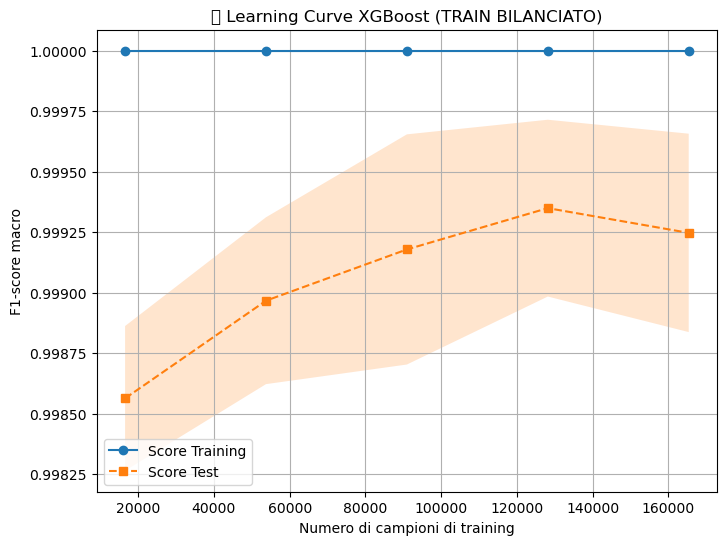

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\maria\AppData\Local\Temp\ipykernel_20144\3853955959.py:58: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  plt.tight_layout()



🌟 Feature Importance (Importanza delle Caratteristiche XGBoost):
- Evidenzia quali latent features influenzano maggiormente il modello.
- Maggiore valore → maggiore contributo alla decisione.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


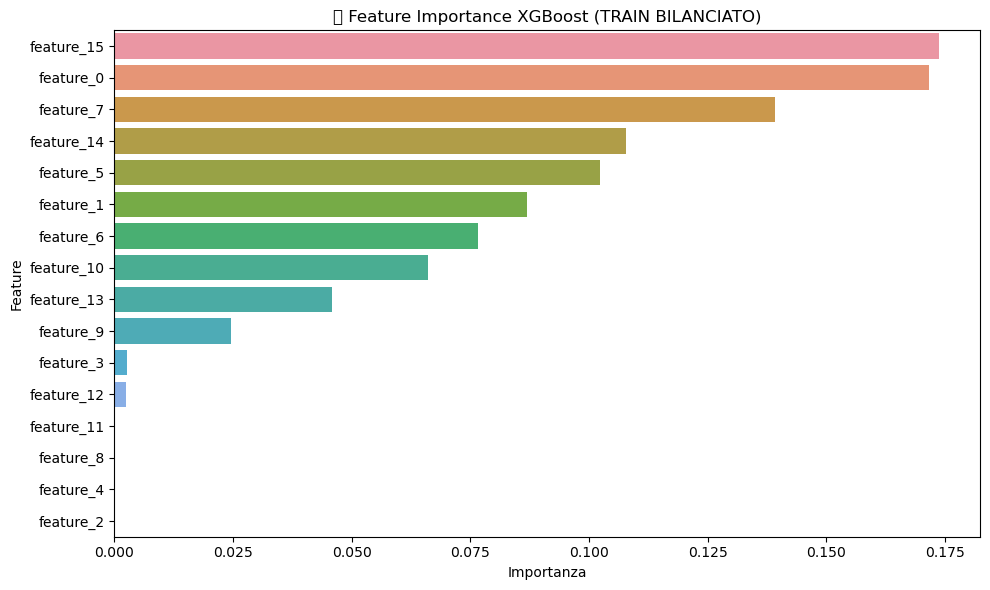

In [ ]:
# ==========================================================
# 📊 Metriche avanzate e grafici per XGBoost (SBILANCIATO)
# ==========================================================
print("\n📊 Generazione grafici e visualizzazioni avanzate per XGBoost **SBILANCIATO**...\n")

from sklearn.metrics import (
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================================
# 1️⃣ Learning Curve
# ==========================================================
print("🧩 **Learning Curve** — XGBoost:\n"
      "- Train >> Test → possibile overfitting\n"
      "- Curve vicine → buona generalizzazione\n")

train_sizes, train_scores, test_scores = learning_curve(
    best_xgb,
    X_train_df,
    y_train_num,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean, test_mean = train_scores.mean(axis=1), test_scores.mean(axis=1)
train_std, test_std = train_scores.std(axis=1), test_scores.std(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, marker='o', label="Train score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, marker='s', linestyle='--', label="Test score")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve — XGBoost (SBILANCIATO)")
plt.legend(); plt.grid(); plt.show()

# ==========================================================
# 2️⃣ Confusion Matrix
# ==========================================================
print("\n📊 **Confusion Matrix** — distribuzione errori per classe\n"
      "- Diagonale = corrette\n"
      "- Off diag = errori\n")

plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    best_xgb, X_test_df, y_test_num, cmap="Blues", normalize="true"
)
plt.title("📊 Confusion Matrix Normalizzata — XGBoost (SBILANCIATO)")
plt.show()

# ==========================================================
# 3️⃣ Precision–Recall Curve multiclasse
# ==========================================================
print("\n🎯 **Precision–Recall Curve** — utile in dataset sbilanciati\n"
      "- AP più alto → migliore rilevamento classi minoritarie\n")

y_test_bin = label_binarize(y_test_num, classes=np.unique(y_train_num))
y_score = best_xgb.predict_proba(X_test_df)

plt.figure(figsize=(8,6))
for i, cls in enumerate(np.unique(y_train_num)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{inverse_mapping[cls]} (AP={ap:.2f})")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("📈 Precision–Recall Curve — XGBoost (SBILANCIATO)")
plt.legend(); plt.grid(); plt.show()

# ==========================================================
# 4️⃣ ROC Curve multiclasse
# ==========================================================
print("\n📈 **ROC Curve** — XGBoost\n"
      "- AUC vicino a 1 → eccellente separabilità\n")

plt.figure(figsize=(8,6))
for i, cls in enumerate(np.unique(y_train_num)


In [ ]:
# ==========================================================
# BLOCCO MLP ottimizzato (CV veloce + TRAIN SBILANCIATO finale)
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
import time
import warnings
warnings.filterwarnings('ignore')

print("🏗️ Addestramento MLP ottimizzato (CV veloce + pesi finali)...\n")

# ==========================================================
# 1️⃣ Standardizzazione + LabelEncoder
# ==========================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

classes = le.classes_  # Array delle classi originali

# Pesi solo per il training finale
sample_weights_train = np.array([class_weights[y] for y in y_train])

# ==========================================================
# 2️⃣ Griglia di parametri per CV veloce
# ==========================================================
param_grid = [
    {'hidden_layer_sizes': (128, 64), 'alpha': 0.001, 'learning_rate_init': 0.001},
    {'hidden_layer_sizes': (64, 32), 'alpha': 0.01, 'learning_rate_init': 0.001},
    {'hidden_layer_sizes': (256, 128), 'alpha': 0.0001, 'learning_rate_init': 0.0005}
]

# ==========================================================
# 3️⃣ CV 3-fold senza pesi per velocità
# ==========================================================
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
best_params = None
best_f1 = 0

for i, params in enumerate(param_grid, 1):
    print(f"\n⚙️ Combinazione {i}/{len(param_grid)} → {params}")
    start_time = time.time()
    
    fold_scores = []
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train_num), 1):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train_num[train_idx], y_train_num[val_idx]

        mlp = MLPClassifier(
            hidden_layer_sizes=params['hidden_layer_sizes'],
            alpha=params['alpha'],
            learning_rate_init=params['learning_rate_init'],
            activation='relu',
            solver='adam',
            batch_size=64,
            max_iter=200,
            early_stopping=True,
            n_iter_no_change=20,
            random_state=42,
            verbose=False
        )
        mlp.fit(X_tr, y_tr)  # CV senza sample_weights
        y_pred = mlp.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        fold_scores.append(f1)
        print(f"   📈 Fold {fold_idx}/3 → F1_macro = {f1:.4f}")
    
    mean_f1 = np.mean(fold_scores)
    std_f1 = np.std(fold_scores)
    elapsed = time.time() - start_time
    print(f"✅ Combinazione {i} completata in {elapsed:.2f}s | F1 medio = {mean_f1:.4f} ± {std_f1:.4f}\n")
    
    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_params = params

# ==========================================================
# 4️⃣ Training finale con il miglior set di parametri e pesi
# ==========================================================
print(f"\n✅ Miglior set di parametri selezionato: {best_params}")
best_model = MLPClassifier(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    alpha=best_params['alpha'],
    learning_rate_init=best_params['learning_rate_init'],
    activation='relu',
    solver='adam',
    batch_size=64,
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=30,
    random_state=42,
    verbose=False
)
best_model.fit(X_train_scaled, y_train_num, sample_weight=sample_weights_train)

# ==========================================================
# 5️⃣ Funzione metriche avanzata
# ==========================================================
def print_metrics(y_true, y_pred, name, classes):
    classes_num = np.arange(len(classes))  # codici numerici
    
    # Metriche globali
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(f"\n📊 Metriche sul {name} set:")
    print(f"Accuracy:            {acc:.4f}")
    print(f"Balanced Accuracy:   {bal_acc:.4f}")
    print(f"Precision (macro):   {prec:.4f}")
    print(f"Recall (macro):      {rec:.4f}")
    print(f"F1-score (macro):    {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes_num)

    # Specificità e F1 per classe + tabella
    metrics = []
    for i, cls in enumerate(classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_cls = f1_score((y_true == i).astype(int), (y_pred == i).astype(int))
        metrics.append([cls, spec, f1_cls])

    df_metrics = pd.DataFrame(metrics, columns=["Classe", "Specificità", "F1 Classe"])
    print("\n📌 Metriche per classe:")
    print(df_metrics.to_string(index=False))

    # Classification report
    print("\n🧾 Classification Report:")
    report = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print(report)

    return f1

# ==========================================================
# 6️⃣ Valutazione finale
# ==========================================================
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

train_f1 = print_metrics(y_train_num, y_train_pred, "TRAIN", classes)
test_f1 = print_metrics(y_test_num, y_test_pred, "TEST", classes)

# Gap F1 per over/underfitting
gap = train_f1 - test_f1
if gap > 0.05:
    print(f"\n⚠️ Possibile overfitting: gap F1 = {gap:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile underfitting: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato senza over/underfitting evidente.")


🏗️ Addestramento MLP ottimizzato (CV veloce + pesi finali)...


⚙️ Combinazione 1/3 → {'hidden_layer_sizes': (128, 64), 'alpha': 0.001, 'learning_rate_init': 0.001}
   📈 Fold 1/3 → F1_macro = 0.9983
   📈 Fold 2/3 → F1_macro = 0.9991
   📈 Fold 3/3 → F1_macro = 0.9991
✅ Combinazione 1 completata in 702.49s | F1 medio = 0.9989 ± 0.0004


⚙️ Combinazione 2/3 → {'hidden_layer_sizes': (64, 32), 'alpha': 0.01, 'learning_rate_init': 0.001}
   📈 Fold 1/3 → F1_macro = 0.9984
   📈 Fold 2/3 → F1_macro = 0.9991
   📈 Fold 3/3 → F1_macro = 0.9989
✅ Combinazione 2 completata in 426.44s | F1 medio = 0.9988 ± 0.0003


⚙️ Combinazione 3/3 → {'hidden_layer_sizes': (256, 128), 'alpha': 0.0001, 'learning_rate_init': 0.0005}
   📈 Fold 1/3 → F1_macro = 0.9985
   📈 Fold 2/3 → F1_macro = 0.9988
   📈 Fold 3/3 → F1_macro = 0.9992
✅ Combinazione 3 completata in 337.17s | F1 medio = 0.9988 ± 0.0003


✅ Miglior set di parametri selezionato: {'hidden_layer_sizes': (128, 64), 'alpha': 0.001, 'learning_rate_init': 0.00

In [ ]:
# ==========================================================
# BLOCCO — Metriche avanzate, grafici e interpretazione MLP (SBILANCIATO)
# ==========================================================
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n📊 Generazione grafici avanzati per MLP **SBILANCIATO**...\n")

# ==========================================================
# 1️⃣ Learning Curve
# ==========================================================
print("🧩 **Learning Curve** — MLP (SBILANCIATO)\n"
      "- Train molto più alto del test → possibile overfitting.\n"
      "- Curve vicine → buon bilanciamento.\n")

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train_num, cv=3, scoring='f1_macro', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, marker='o', label="Train")
plt.plot(train_sizes, test_mean, marker='s', label="Test")
plt.title("📈 Learning Curve — MLP (SBILANCIATO)")
plt.xlabel("Training samples")
plt.ylabel("F1-macro")
plt.grid(True)
plt.legend()
plt.show()

# ==========================================================
# 2️⃣ Confusion Matrix
# ==========================================================
print("\n📊 **Confusion Matrix** — MLP (SBILANCIATO)\n")

plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test_scaled, y_test_num, cmap="Blues", normalize="true"
)
plt.title("📊 Confusion Matrix Normalizzata — MLP (SBILANCIATO)")
plt.show()

# ==========================================================
# 3️⃣ Precision-Recall Curve (multiclasse)
# ==========================================================
print("\n🎯 **Precision–Recall Curve** — MLP (SBILANCIATO)\n"
      "- Molto utile nei dataset sbilanciati.\n")

y_test_bin = label_binarize(y_test_num, classes=np.arange(len(classes)))
y_score = best_model.predict_proba(X_test_scaled)

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve — MLP (SBILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 4️⃣ ROC Curve (multiclasse)
# ==========================================================
print("\n📈 **ROC Curve — MLP (SBILANCIATO)**\n")

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve — MLP (SBILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 5️⃣ Feature Importance Proxy (MLP)
# ==========================================================
print("\n🧠 **MLP Feature Importance Proxy** — pesi input → primo layer\n"
      "- Valori alti → feature più influenti sui neuroni iniziali.\n")

input_weights = best_model.coefs_[0]      # shape: [n_features, nodes]
feature_importance = np.sum(np.abs(input_weights), axis=1)

indices = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=feature_importance[indices],
    y=[f"latent_{i}" for i in indices],
    palette="viridis"
)
plt.title("🌟 Feature Importance Proxy — MLP (SBILANCIATO)")
plt.xlabel("Importanza (somma pesi assoluti)")
plt.ylabel("Feature")
plt.show()

print("\n✅ Tutti i grafici MLP (SBILANCIATO) generati con successo!")



🧩 Learning Curve (Curva di Apprendimento MLP):
- Mostra l’evoluzione delle prestazioni al crescere dei dati di training.
- Se curva train >> test → possibile overfitting.
- Se curve vicine e alte → buon equilibrio e generalizzazione.



KeyboardInterrupt: 

In [ ]:
# ==========================================================
# 🔄 Blocco comparativo tra modelli (RF, LGBM, XGB, MLP)
# ==========================================================
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import numpy as np
import xgboost as xgb

# LabelEncoder coerente per tutte le classi
le = LabelEncoder()
le.fit(classes_str)  # classes_str = lista delle classi come stringhe

def ensure_encoded(y, le):
    y = np.asarray(y)
    if y.dtype.type is np.str_ or isinstance(y.flat[0], str):
        return le.transform(y)
    else:
        return y.astype(int)

def preds_to_encoded(preds, model_name, le):
    preds = np.asarray(preds)
    if preds.ndim == 2:  # probabilità → argmax
        preds = np.argmax(preds, axis=1)
        return preds.astype(int)
    if preds.dtype.type is np.str_ or isinstance(preds.flat[0], str):
        return le.transform(preds)
    else:
        return preds.astype(int)

def calc_metrics(model_name, model, X_train, y_train, X_test, y_test):
    y_train_enc = ensure_encoded(y_train, le)
    y_test_enc = ensure_encoded(y_test, le)

    if model_name == "XGBoost":
        y_train_pred = np.argmax(model.predict(xgb.DMatrix(X_train)), axis=1)
        y_test_pred  = np.argmax(model.predict(xgb.DMatrix(X_test)), axis=1)
    else:
        y_train_pred_raw = model.predict(X_train)
        y_test_pred_raw  = model.predict(X_test)
        y_train_pred = preds_to_encoded(y_train_pred_raw, model_name, le)
        y_test_pred  = preds_to_encoded(y_test_pred_raw, model_name, le)

    metrics = {
        "Train F1": f1_score(y_train_enc, y_train_pred, average='macro'),
        "Test F1": f1_score(y_test_enc, y_test_pred, average='macro'),
        "Train Accuracy": accuracy_score(y_train_enc, y_train_pred),
        "Test Accuracy": accuracy_score(y_test_enc, y_test_pred),
        "Train Precision": precision_score(y_train_enc, y_train_pred, average='macro', zero_division=0),
        "Test Precision": precision_score(y_test_enc, y_test_pred, average='macro', zero_division=0),
        "Train Recall": recall_score(y_train_enc, y_train_pred, average='macro', zero_division=0),
        "Test Recall": recall_score(y_test_enc, y_test_pred, average='macro', zero_division=0)
    }
    return metrics

# Dizionario modelli
models = {
    "RandomForest": best_rf,
    "LightGBM": best_lgb,
    "XGBoost": final_model,
    "MLP": best_model
}

# Calcolo metriche per tutti i modelli
summary = {}
for name, model in models.items():
    summary[name] = calc_metrics(
        name, model, X_train_scaled, y_train_num, X_test_scaled, y_test_num
    )

df_summary = pd.DataFrame(summary).T
display(df_summary.round(4))

# ==========================================================
# 🔍 Analisi comparativa Feature Importance
# ==========================================================
feature_names = [f'latent_{i}' for i in range(X_train_scaled.shape[1])]

rf_importances  = best_rf.feature_importances_
lgb_importances = best_lgb.feature_importances_
xgb_importances = final_model.feature_importances_
mlp_importances = np.mean(np.abs(best_model.coefs_[0]), axis=1)  # proxy primo layer

df_feat = pd.DataFrame({
    'Feature': feature_names,
    'RandomForest': rf_importances,
    'LightGBM': lgb_importances,
    'XGBoost': xgb_importances,
    'MLP (proxy)': mlp_importances
})

# Normalizzazione 0-1
df_feat_norm = df_feat.copy()
for col in ['RandomForest','LightGBM','XGBoost','MLP (proxy)']:
    df_feat_norm[col] = df_feat_norm[col] / df_feat_norm[col].sum()

# Visualizzazione top 10 feature per modello
top_n = 10
for model_col in ['RandomForest','LightGBM','XGBoost','MLP (proxy)']:
    print(f"\nTop {top_n} feature per {model_col}:")
    display(df_feat_norm[['Feature', model_col]].sort_values(model_col, ascending=False).head(top_n))

# Heatmap comparativa
plt.figure(figsize=(20,8))
sns.heatmap(
    df_feat_norm.set_index('Feature').T,
    cmap="viridis",
    annot=False,
    linewidths=0.5,
    cbar_kws={'label': 'Importanza normalizzata'}
)
plt.title("🌟 Comparazione Feature Importance Normalizzate tra Modelli", fontsize=16)
plt.ylabel("Modello", fontsize=12)
plt.xlabel("Feature Latenti", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()
